(234, 224, 224, 3) (234, 12)
Epoch 1/150
35/35 [==============================] - ETA: 0s - loss: 18.3030 - accuracy: 0.4542

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 73s 2s/step - loss: 18.3030 - accuracy: 0.4542 - val_loss: 15.1062 - val_accuracy: 0.5043
Epoch 2/150
35/35 [==============================] - 63s 2s/step - loss: 9.9734 - accuracy: 0.6676 - val_loss: 12.8140 - val_accuracy: 0.5598
Epoch 3/150
35/35 [==============================] - 71s 2s/step - loss: 8.4636 - accuracy: 0.7060 - val_loss: 9.1682 - val_accuracy: 0.6709
Epoch 4/150
35/35 [==============================] - 71s 2s/step - loss: 7.5054 - accuracy: 0.7335 - val_loss: 8.0297 - val_accuracy: 0.7051
Epoch 5/150
35/35 [==============================] - 60s 2s/step - loss: 6.6214 - accuracy: 0.7683 - val_loss: 7.4794 - val_accuracy: 0.7521
Epoch 6/150
35/35 [==============================] - 60s 2s/step - loss: 6.5709 - accuracy: 0.7692 - val_loss: 7.2226 - val_accuracy: 0.7436
Epoch 7/150
35/35 [==============================] - 60s 2s/step - loss: 6.2289 - accuracy: 0.7885 - val_loss: 7.5142 - val_accuracy: 0.7265
Epoch 8/150
35/35 [===

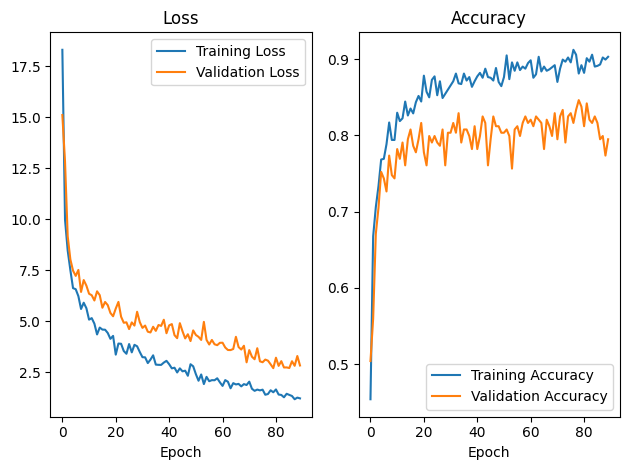

8/8 [==============================] - 8s 1s/step - loss: 2.3055 - accuracy: 0.8376
Accuracy on test set: 0.8376068472862244
8/8 [==============================] - 9s 986ms/step


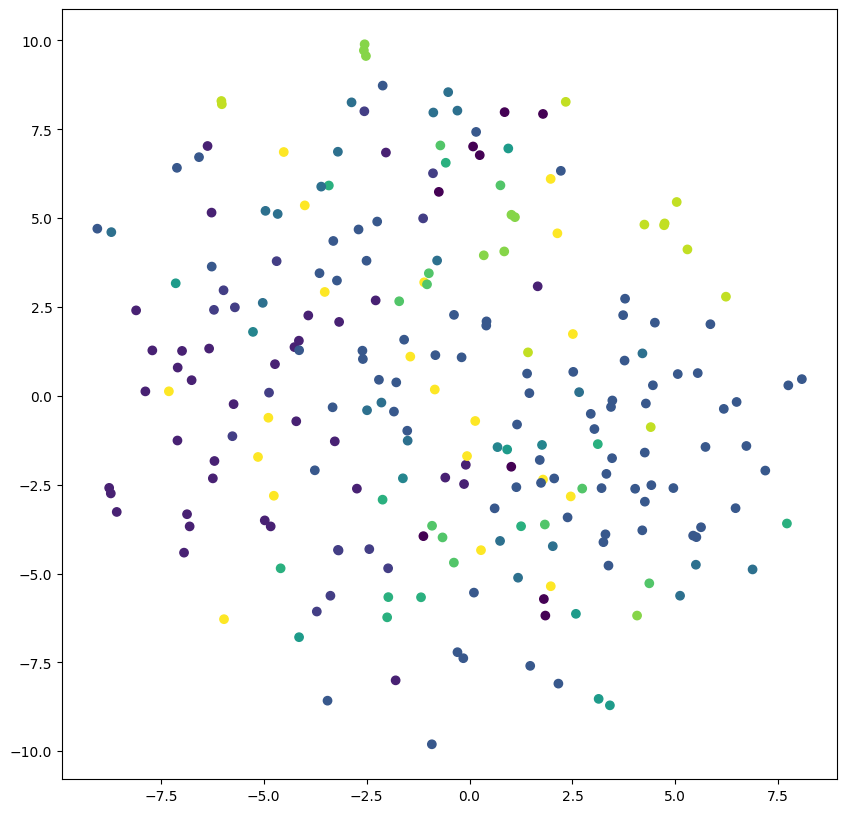

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Load LFW dataset

# Load LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.4)
n_samples, h, w = lfw_people.images.shape
if n_samples > 7000:
    n_samples = 7000
    lfw_people.images = lfw_people.images[:n_samples]
    lfw_people.data = lfw_people.data[:n_samples]
    lfw_people.target = lfw_people.target[:n_samples]
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Resize the images to 96x96 and Expand the input data to have a fourth dimension
X_train = []
for img in lfw_people.images:
    resized_img = cv2.resize(img, (224, 224))
    # Repeat the grayscale image across three channels
    three_channel_img = np.repeat(resized_img[..., np.newaxis], 3, -1)
    X_train.append(three_channel_img)
X_train = np.array(X_train)

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

# One-hot encode the targets
y_train = to_categorical(y_train, num_classes=n_classes)
y_val = to_categorical(y_val, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)
print(X_val.shape,y_val.shape)
# Your preprocessing code here...

# Define the dynamic margin loss function
# Define the dynamic margin loss function
batch_size = 32

def get_dynamic_margin_loss(optimizer, margin=0.25, scale=50.0):
    class DynamicMarginLoss(tf.keras.losses.Loss):
        def __init__(self, margin, scale, reduction=tf.keras.losses.Reduction.AUTO, name='dynamic_margin_loss'):
            super().__init__(reduction=reduction, name=name)
            self.margin = margin
            self.scale = scale

        def call(self, y_true, y_pred):
            epoch = tf.cast(optimizer.iterations, tf.float32) / tf.cast((n_samples / batch_size), tf.float32)
            dynamic_margin = self.margin * (1 - 0.01 * epoch)
            y_pred = y_true * (y_pred - dynamic_margin) + (1 - y_true) * y_pred
            y_pred *= self.scale
            return tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
    return DynamicMarginLoss(margin, scale)

## Define the model architecture

base_model = MobileNetV2(weights='imagenet', include_top=False)
base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs)
x=GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(n_classes)(x)

outputs = Lambda(lambda x: K.l2_normalize(x,axis=1))(x)

model = Model(inputs, outputs)

initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)
loss = get_dynamic_margin_loss(optimizer, margin=0.25, scale=50.0)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True)

history = model.fit(datagen.flow(X_train, y_train), epochs=150,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping_cb, checkpoint_cb])

model.load_weights("best_model.h5")

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

results = model.evaluate(X_test, y_test)
accuracy = results[1]

print(f"Accuracy on test set: {accuracy}")
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assume that model is your trained model
feature_model = Model(inputs=model.input, outputs=model.layers[-3].output)

# Use feature_model to predict on your data and get the feature embeddings
embeddings = feature_model.predict(X_test)

# Use t-SNE to reduce dimensionality of embeddings to 2D
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings, coloring each point by the class label
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=np.argmax(y_test, axis=1))
plt.show()


8/8 [==============================] - 16s 2s/step


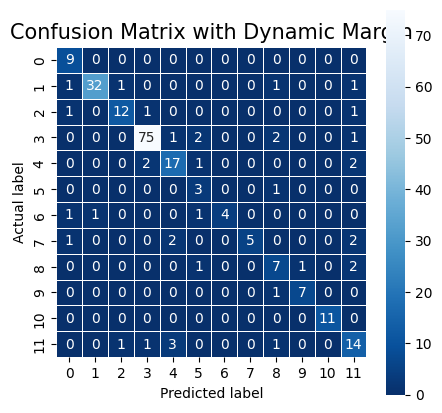

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)
y_true_classes = np.argmax(y_test,axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix with Dynamic Margin', size=15)
plt.show()

In [ ]:
# Classification report
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(n_classes)]
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=target_names))

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.69      1.00      0.82         9
     Class 1       0.97      0.89      0.93        36
     Class 2       0.86      0.80      0.83        15
     Class 3       0.95      0.93      0.94        81
     Class 4       0.74      0.77      0.76        22
     Class 5       0.38      0.75      0.50         4
     Class 6       1.00      0.57      0.73         7
     Class 7       1.00      0.50      0.67        10
     Class 8       0.54      0.64      0.58        11
     Class 9       0.88      0.88      0.88         8
    Class 10       1.00      1.00      1.00        11
    Class 11       0.61      0.70      0.65        20

    accuracy                           0.84       234
   macro avg       0.80      0.79      0.77       234
weighted avg       0.86      0.84      0.84       234

